# Figure 1

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Scientific and datavis stack
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
from cmcrameri import cm

In [3]:
# My packages
from aeolus.calc import spatial, spatial_mean, time_mean, zonal_mean
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units
from pouch.clim_diag import (
    calc_derived_cubes,
    latitude_of_max_zonal_wind,
    ratio_of_dn_to_eq_pole_temp_diff,
)
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    YLOCS,
    figsave,
    linspace_pm1,
    use_style,
)

In [4]:
# Local modules
import mypaths
from commons import (
    GLM_SUITE_ID,
    OPT_LABELS,
    REGIMES,
    SENS_EXP_GROUPS,
    SIM_LABELS,
    eq_lat,
    free_troposphere,
    troposphere,
)

Apply custom matplotlib style sheet.

In [5]:
use_style()

### Load all sensitivity experiments

Define paths to input data and results.

In [6]:
img_prefix = f"{GLM_SUITE_ID}_mean"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_mean"
# time_prof = "mean_days6000_9950"
plotdir = mypaths.plotdir / img_prefix

Load processed data.

In [7]:
sim_prop = SIM_LABELS["base"]
runs = {}
runs_p = {}
for sim_label, _ in OPT_LABELS.items():
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    if sim_label in ["base", "sens-llcs_all_rain", "sens-startswap"]:
        time_prof = "mean_days6000_9950"
    elif sim_label == "sens-noradcld":
        time_prof = "mean_days2000_2200"
    else:
        time_prof = "mean_days2000_2950"
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )

    add_planet_conf_to_cubes(cl, const)
    # Use the cube list to initialise an AtmoSim object
    calc_derived_cubes(cl, const=const)
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
    )
    # Cubes on pressure levels
    cl_p = load_data(inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}_plev.nc")
    runs_p[sim_label] = AtmoSim(
        cl_p,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
        vert_coord="p",
    )

Choose the type of time-reducing operation: time mean.

In [8]:
time_reduce = lambda cube: time_mean(cube, model=um)

Define two key pressure levels (also used for other figures).

In [9]:
P_LEV1 = 300  # hPa
p_lev_constr1 = iris.Constraint(**{um.pres: P_LEV1 * 1e2})
P_LEV2 = 500  # hPa
p_lev_constr2 = iris.Constraint(**{um.pres: P_LEV2 * 1e2})

Average temperature and zonal wind over time and longitude and store the results in a separate dictionary.

In [10]:
RESULTS_VCROSS = {}
for sim_label in SIM_LABELS.keys():
    RESULTS_VCROSS[sim_label] = {}

    the_run = runs[sim_label]
    RESULTS_VCROSS[sim_label]["lons"] = the_run.coord.x.points
    RESULTS_VCROSS[sim_label]["lats"] = the_run.coord.y.points
    RESULTS_VCROSS[sim_label]["sigma_p"] = time_mean(spatial_mean(the_run.sigma_p))
    RESULTS_VCROSS[sim_label]["sigma_p_lev1"] = (
        P_LEV1 * 1e2 / the_run.const.reference_surface_pressure.data
    )
    RESULTS_VCROSS[sim_label]["sigma_p_lev2"] = (
        P_LEV2 * 1e2 / the_run.const.reference_surface_pressure.data
    )

    RESULTS_VCROSS[sim_label]["u_cross"] = time_mean(zonal_mean(the_run.u))
    RESULTS_VCROSS[sim_label]["temp_cross"] = time_mean(zonal_mean(the_run.temp))

Define global climate diagnostics for all sensitivity experiments (more diagnostics are listed at the end of the notebook).

In [11]:
DIAGS = {
    "t_sfc_min": {
        "cube": lambda AS: spatial(AS.t_sfc, "min"),
        "title": "Minimum surface temperature",
        "short_title": "$T_{s,min}$",
        "tex_units": "$K$",
        "lim": [165, 220],
        "fmt": lambda x: f"{x:.1f}",
    },
    "jet_lat_free_trop": {
        "cube": lambda AS: latitude_of_max_zonal_wind(AS.u.extract(free_troposphere)),
        "title": "Latitude of the tropospheric jet",
        "short_title": "$\phi_{u_{max}}$",
        "tex_units": "$\degree$",
        "lim": [15, 75],
        "ticks": [0, 30, 60, 90],
        "fmt": lambda x: f"{x:.1f}",
    },
    "ratio_dn_ep_temp_diff_trop": {
        "cube": lambda AS: ratio_of_dn_to_eq_pole_temp_diff(AS.extract(troposphere)),
        "title": "Ratio of the day-night to\nequator-pole temperature difference",
        "short_title": r"$\Delta T_{dn}/\Delta T_{ep}$",
        "tex_units": "1",
        "lim": [0.1, 1.1],
        "fmt": lambda x: f"{x:.1f}",
    },
    f"u_max_eq_jet_{P_LEV1}hpa": {
        "source": "p",
        "cube": lambda AS: spatial(AS.u.extract(p_lev_constr1 & eq_lat), "max"),
        "title": f"Maximum zonal wind at the equator at {P_LEV1} hpa",
        "short_title": r"$u_{eq,max}$",
        "tex_units": "$m$ $s^{-1}$",
        "lim": [30, 85],
        "source": "p",
        "fmt": lambda x: f"{x:.1f}",
    },
}

Do the calculations for each of the diagnostics and store results in a separate dictionary.

In [12]:
RESULTS = {}
for vrbl_key, vrbl_prop in DIAGS.items():
    RESULTS[vrbl_key] = {}
    for sim_label in OPT_LABELS.keys():
        if vrbl_prop.get("source", "") == "p":
            the_run = runs_p[sim_label]
        else:
            the_run = runs[sim_label]

        # Calculate diagnostics
        cube = time_reduce(vrbl_prop["cube"](the_run))
        try:
            cube.convert_units(tex2cf_units(vrbl_prop["tex_units"]))
        except ValueError:
            pass
        RESULTS[vrbl_key][sim_label] = cube

Convert the results into a pandas DataFrame.

In [13]:
dfs = {}
for sim_label, sim_prop in OPT_LABELS.items():
    _data = {}
    for vrbl_key, vrbl_prop in DIAGS.items():
        _data[vrbl_prop["short_title"]] = float(RESULTS[vrbl_key][sim_label].data)
    dfs[sim_label] = pd.DataFrame(
        _data,
        index=pd.Index(name="Experiment", data=[sim_prop["title"]]),
    )

df = pd.concat(dfs, axis="index").droplevel(0)

formatters = {
    k: {j["short_title"]: j["fmt"] for j in DIAGS.values()}[k] for k in df.columns
}

# df.columns = [fr"\colhead{{{i}}}" for i in df.columns]
# print(
#     df.to_latex(
#         formatters=formatters,
#         column_format="l" + "c" * len(DIAGS),
#         escape=False,
#     )
# )

Arrange variables into pairs for plotting.

In [14]:
vrbl_pairs = [
    ["u_max_eq_jet_300hpa", "jet_lat_free_trop"],
    ["ratio_dn_ep_temp_diff_trop", "t_sfc_min"],
]

In [15]:
# for vrbl_key_x, vrbl_key_y in tqdm(itertools.combinations(DIAGS.keys(), 2)):
# {'_'.join([i.replace('sens-','') for i in OPT_LABELS.keys()])}
imgname = f"{img_prefix}__all_sim__{'_'.join([i for j in vrbl_pairs for i in j])}__u_temp_vcross"
kw_plt_common = {"linewidth": 0, "ms": 10, "mec": "tab:grey"}
fig = plt.figure(figsize=(15, 11), constrained_layout=True)
mosaic = [["."] + ["-".join(i)] * 2 + ["."] * 2 for i in vrbl_pairs]
mosaic += [
    [i for i in [f"vcross-{sim_label}" for sim_label in SIM_LABELS] for _ in range(2)]
    + ["vcross-cax"]
]
axd = fig.subplot_mosaic(
    mosaic,
    gridspec_kw={"width_ratios": [1, 1, 1, 1, 0.05], "height_ratios": [1, 1, 0.75]},
)
iletters = subplot_label_generator()
for ax in axd.values():
    if not ax.get_label().endswith("-cax"):
        ax.set_title(next(iletters), **KW_SBPLT_LABEL)
for sim_label, sim_prop in SIM_LABELS.items():
    ax = axd[f"vcross-{sim_label}"]
    ax.set_title(
        f'{sim_prop["title"]} - {OPT_LABELS[sim_label]["regime"]} regime',
        color=sim_prop["kw_plt"]["color"],
        **KW_MAIN_TTL,
    )
    ax.set_xticks(YLOCS)
    ax.set_xlabel("Latitude [$\degree$]", fontsize="small")
    ax.set_xlim((-90, 90))
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"$\sigma=p/p_s$", fontsize="small")
    ax.set_ylim((1, 0))
    ax.set_title("Zonal mean", **KW_AUX_TTL)

    ax.axhline(
        y=RESULTS_VCROSS[sim_label]["sigma_p_lev1"],
        color="tab:grey",
        linewidth=2,
        linestyle=":",
        dash_capstyle="round",
    )
    ax.axhline(
        y=RESULTS_VCROSS[sim_label]["sigma_p_lev2"],
        color="tab:red",
        linewidth=2,
        linestyle=":",
        dash_capstyle="round",
    )
    _p2 = ax.contourf(
        RESULTS_VCROSS[sim_label]["lats"],
        RESULTS_VCROSS[sim_label]["sigma_p"].data,
        RESULTS_VCROSS[sim_label]["u_cross"].data,
        levels=linspace_pm1(7) * 70,
        cmap=cm.vik,
        extend="both",
    )
    _p3 = ax.contour(
        RESULTS_VCROSS[sim_label]["lats"],
        RESULTS_VCROSS[sim_label]["sigma_p"].data,
        RESULTS_VCROSS[sim_label]["temp_cross"].data,
        levels=np.arange(100, 1000, 5),
        cmap=cm.batlow,
        norm=mpl.colors.Normalize(vmin=210, vmax=260),
        extend="both",
    )
    ax.clabel(_p3, fmt="%.0f")
cbar = fig.colorbar(_p2, cax=axd["vcross-cax"])
cbar.ax.set_ylabel("Zonal wind [$m$ $s^{-1}$]")

for vrbl_key_x, vrbl_key_y in vrbl_pairs:
    ax = axd[f"{vrbl_key_x}-{vrbl_key_y}"]
    xlabel = DIAGS[vrbl_key_x]["title"]
    if (units_x := DIAGS[vrbl_key_x]["tex_units"]) != "1":
        xlabel += f" [{units_x}]"
    ylabel = DIAGS[vrbl_key_y]["title"]
    if (units_y := DIAGS[vrbl_key_y]["tex_units"]) != "1":
        ylabel += f" [{units_y}]"

    ax.set(
        xlim=DIAGS[vrbl_key_x].get("lim"),
        xlabel=xlabel,
        xscale=DIAGS[vrbl_key_x].get("scale", "linear"),
        ylim=DIAGS[vrbl_key_y].get("lim"),
        ylabel=ylabel,
        yscale=DIAGS[vrbl_key_y].get("scale", "linear"),
    )

    texts = []
    for sim_label, sim_prop in OPT_LABELS.items():
        kw_plt = SENS_EXP_GROUPS[sim_prop.get("group", "base")]["kw_plt"]
        ax.plot(
            RESULTS[vrbl_key_x][sim_label].data,
            RESULTS[vrbl_key_y][sim_label].data,
            **kw_plt_common,
            **REGIMES[sim_prop["regime"]]["kw_plt"],
            **kw_plt,
        )
        texts.append(
            ax.text(
                RESULTS[vrbl_key_x][sim_label].data,
                RESULTS[vrbl_key_y][sim_label].data,
                sim_prop["title"],
                color=REGIMES[sim_prop["regime"]]["kw_plt"]["color"],
                fontstyle="italic",
                fontweight="bold",
            )
        )
    adjust_text(
        texts,
        ax=ax,
        force_text=(1.0, 1.0),
        arrowprops=dict(arrowstyle="->", color="tab:grey", alpha=0.75),
    )
    if ax.get_subplotspec().is_first_row():
        add_custom_legend(
            ax,
            {
                group_prop["title"]: {
                    "color": "tab:grey",
                    **kw_plt_common,
                    **group_prop["kw_plt"],
                }
                for _, group_prop in SENS_EXP_GROUPS.items()
            },
            loc="upper left",
            bbox_to_anchor=(1.0, 1.0),
            frameon=False,
            ncol=1,
            title="Groups of\nsensitivity\nexperiments",
            handletextpad=-0.2,
        )
        add_custom_legend(
            ax,
            {
                name: {
                    "marker": "o",
                    **kw_plt_common,
                    **prop["kw_plt"],
                }
                for name, prop in REGIMES.items()
            },
            loc="upper left",
            bbox_to_anchor=(1.25, 1.0),
            frameon=False,
            ncol=1,
            title="\nCirculation\nregimes",
            handletextpad=-0.2,
        )

plt.close()

# Show the figure

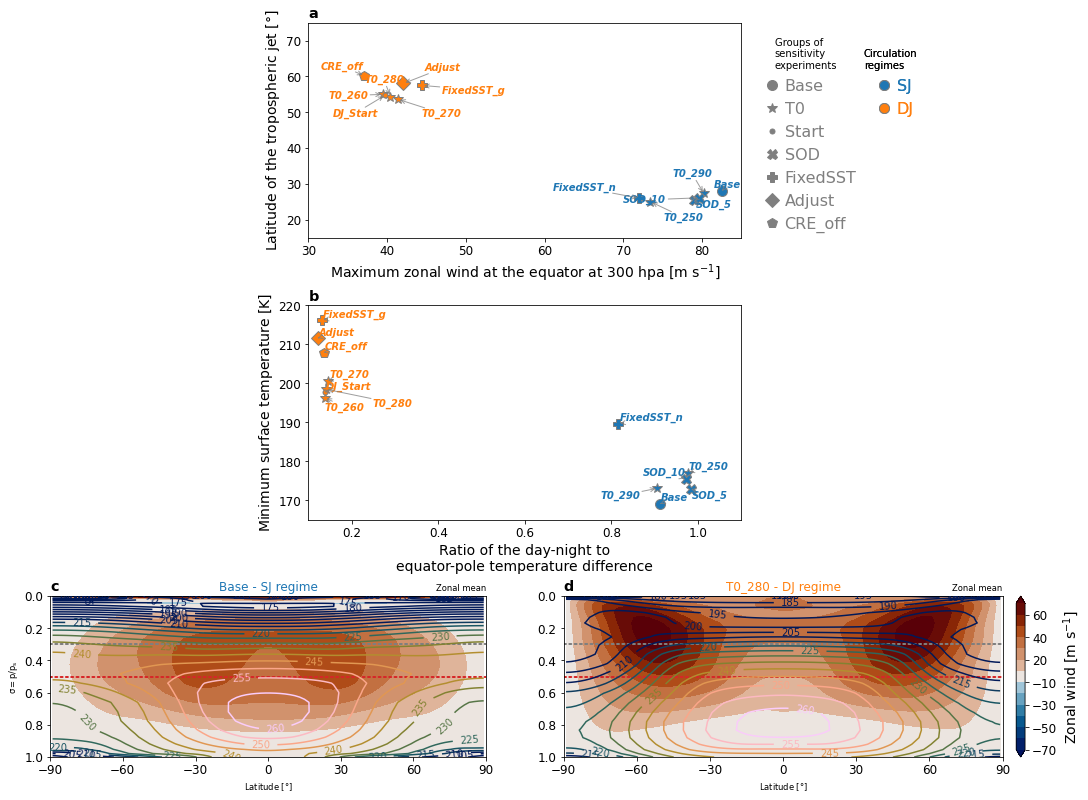

In [16]:
fig

The mean climate diagnostics in all experiments: (a) maximum equatorial zonal wind speed (x-axis, $m$ $s^{-1}$) and the latitude of the tropospheric jet (y-axis, degrees); (b) the ratio of the day-night to equator-pole temperature difference (x-axis) and the minimum surface temperature (y-axis, $K$).

Experiments that produce the SJ regime are shown in blue, DJ --- in orange. Different marker shapes correspond to different groups of sensitivity experiments. Configuration labels are defined in Table 2.

Also shown is the steady state of the (c) SJ and (d) DJ circulation regimes in the indicative simulations (_Base_ and _T0\_280_, respectively). Panels c and d show the vertical cross-section of the zonal mean eastward wind (shading, $m$ $s^{-1}$) and zonal mean air temperature (contours, $K$). Horizontal dashed lines in c and d show the corresponding pressure level of the horizontal cross-sections of (red) temperature and (gray) winds and geopotential height shown in Fig. 7.

"Single Jet" (SJ) and "Double Jet" (DJ) are short-hand descriptive terms rather than precise descriptions: the equatorial jet in the SJ regime exhibits a split at $\sigma\approx 0.5$, and the DJ regime still has an equatorial superrotation, albeit weaker than that in the SJ regime.

And save it.

In [17]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_mean/ch111_mean__all_sim__u_max_eq_jet_300hpa_jet_lat_free_trop_ratio_dn_ep_temp_diff_trop_t_sfc_min__u_temp_vcross.png


---

# Extra

In [ ]:
from aeolus.calc import abs_coord_mean, bond_albedo, vertical_mean
from commons import DAYSIDE, NIGHTSIDE, cold_traps
from pouch.clim_diag import (
    calc_derived_cubes,
    d_dphi,
    hgt_cnstr_0_1km,
    latent_heating_rate,
    latitude_of_max_zonal_wind,
    longitude_of_wave_crest,
    mean_dry_lapse_rate,
    moist_static_energy,
    ratio_of_dn_to_eq_pole_temp_diff,
    upper_atm_vap_mean,
)
from pouch.plot import AXGR

In [ ]:
DIAGS = {
    "dtdz_0_1km": {
        "cube": lambda AS, model=um: spatial(
            mean_dry_lapse_rate(AS._cubes.extract(hgt_cnstr_0_1km), model=model), "mean"
        ),
        "title": "Lapse rate between 0 and 1 km",
        "short_title": r"$dT/dz$",
        "tex_units": "$K$ $km^{-1}$",
        "fmt": lambda x: f"{x:.1f}",
        "lim": [10, 25],
    },
    "up_atm_wv": {
        "cube": lambda AS: spatial(upper_atm_vap_mean(AS._cubes), "mean"),
        "title": "Specific humidity at 100 hPa",
        "short_title": r"$q_{100hPa}$",
        "tex_units": "$kg$ $kg^{-1}$",
        "fmt": lambda x: rf"\num{{{x:.1e}}}",
        "lim": [1e-8, 1e-6],
        "scale": "log",
    },
    "up_atm_wv_10hpa": {
        "cube": lambda AS: spatial(upper_atm_vap_mean(AS._cubes, levels=0.01), "mean"),
        "title": "Specific humidity at 10 hPa",
        "short_title": r"$q_{10hPa}$",
        "tex_units": "$kg$ $kg^{-1}$",
        "fmt": lambda x: rf"\num{{{x:.1e}}}",
        "lim": [5e-9, 1e-6],
        "scale": "log",
    },
    "up_atm_wv_term": {
        "cube": lambda AS: spatial(
            upper_atm_vap_mean(
                AS._cubes.extract(iris.Constraint(**{um.x: lambda x: x in [-90, 90]}))
            ),
            "mean",
        ),
        "title": "Specific humidity at 100 hPa\nat the terminators",
        "short_title": r"$q_{100hPa,term}$",
        "tex_units": "$kg$ $kg^{-1}$",
        "fmt": lambda x: rf"\num{{{x:.1e}}}",
        "lim": [1e-8, 1e-6],
        "scale": "log",
    },
    "b_alb_gm": {
        "cube": lambda AS: spatial(bond_albedo(AS._cubes), "mean"),
        "title": "Bond albedo",
        "short_title": r"$\alpha_b$",
        "tex_units": "1",
        "lim": [0, 0.5],
        "fmt": lambda x: f"{x:.2f}",
    },
    "t_sfc_cold_traps": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(cold_traps)),
        "title": "Surface temperature in cold traps",
        "short_title": "$T_{s,ct}$",
        "tex_units": "$K$",
        "lim": [160, 260],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_d": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(DAYSIDE.constraint)),
        "title": "Mean day-side surface temperature",
        "short_title": "$T_{s,d}$",
        "tex_units": "$K$",
        "lim": [240, 280],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_n": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(NIGHTSIDE.constraint)),
        "title": "Mean day-side surface temperature",
        "short_title": "$T_{s,n}$",
        "tex_units": "$K$",
        "lim": [195, 235],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_min": {
        "cube": lambda AS: spatial(AS.t_sfc, "min"),
        "title": "Minimum surface temperature",
        "short_title": "$T_{s,min}$",
        "tex_units": "$K$",
        "lim": [165, 220],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_max": {
        "cube": lambda AS: spatial(AS.t_sfc, "max"),
        "title": "Maximum surface temperature",
        "short_title": "$T_{s,max}$",
        "tex_units": "$K$",
        "lim": [280, 310],
        "fmt": lambda x: f"{x:.1f}",
    },
    "jet_lat_free_trop": {
        "cube": lambda AS: latitude_of_max_zonal_wind(AS.u.extract(free_troposphere)),
        "title": "Latitude of the tropospheric jet",
        "short_title": "$\phi_{u_{max}}$",
        "tex_units": "$\degree$",
        "lim": [15, 75],
        "ticks": [0, 30, 60, 90],
        "fmt": lambda x: f"{x:.1f}",
    },
    "ratio_dn_ep_temp_diff_trop": {
        "cube": lambda AS: ratio_of_dn_to_eq_pole_temp_diff(AS.extract(troposphere)),
        "title": "Ratio of the day-night to\nequator-pole temperature difference",
        "short_title": r"$\Delta T_{dn}/\Delta T_{ep}$",
        "tex_units": "1",
        "lim": [0.1, 1.1],
        "fmt": lambda x: f"{x:.1f}",
    },
    f"u_mean_eq_jet_{P_LEV}hpa": {
        "source": "p",
        "cube": lambda AS: spatial(AS.u.extract(p_lev_constr & eq_lat), "mean"),
        "title": f"Mean zonal wind at the equator at {P_LEV} hpa",
        "short_title": r"$\overline{u_{eq}}$",
        "tex_units": "$m$ $s^{-1}$",
        "lim": [15, 55],
        "source": "p",
        "fmt": lambda x: f"{x:.1f}",
    },
    f"u_max_eq_jet_{P_LEV}hpa": {
        "source": "p",
        "cube": lambda AS: spatial(AS.u.extract(p_lev_constr & eq_lat), "max"),
        "title": f"Maximum zonal wind at the equator at {P_LEV} hpa",
        "short_title": r"$u_{eq,max}$",
        "tex_units": "$m$ $s^{-1}$",
        "lim": [30, 85],
        "source": "p",
        "fmt": lambda x: f"{x:.1f}",
    },
    "dtemp_dphi_tropmean": {
        "cube": lambda AS: spatial(
            -1
            * abs_coord_mean(
                zonal_mean(
                    d_dphi(
                        vertical_mean(
                            AS.temp.extract(troposphere),
                            weight_by=AS.dens.extract(troposphere),
                        )
                    )
                ),
                um.y,
            ),
            "max",
        ),
        "title": "Meridional gradient\nof the mean tropospheric\ntemperature",
        "short_title": r"$\overline{\Delta T_{ep}}$",
        "tex_units": "$K$ $(1000 km)^{-1}$",
        "lim": [0, 10],
        "ax": 0,
        "fmt": lambda x: f"{x:.1f}",
    },
    "dt_lh_dayside_eq": {
        "cube": lambda AS: time_reduce(
            spatial_mean(
                vertical_mean(
                    latent_heating_rate(AS._cubes), weight_by=AS.dens
                ).extract(DAYSIDE.constraint & eq_lat)
            )
        ),
        "tex_units": "$K$ $day^{-1}$",
        "title": "Dayside latent heating",
        "short_title": r"$(\partial T/\partial t)_{lh}$",
        "lim": [0, 6],
        "fmt": lambda x: f"{x:.1f}",
    },
}

### Maps of surface temperature in the sens-fixedsst experiment

In [25]:
chosen_opt_labels = ["sens-fixedsst", "sens-fixedsst-day-night"]

216.12091064453125 293.79986572265625
189.56198120117188 287.4574279785156
170.6182403564453 287.4574279785156
170.6182403564453 293.79986572265625
Saved to ../../plots/sa/ch111/ch111_mean/ch111_mean__grcs_llcs__sens-fixedsst_sens-fixedsst-day-night__t_sfc_300hpa_winds.png


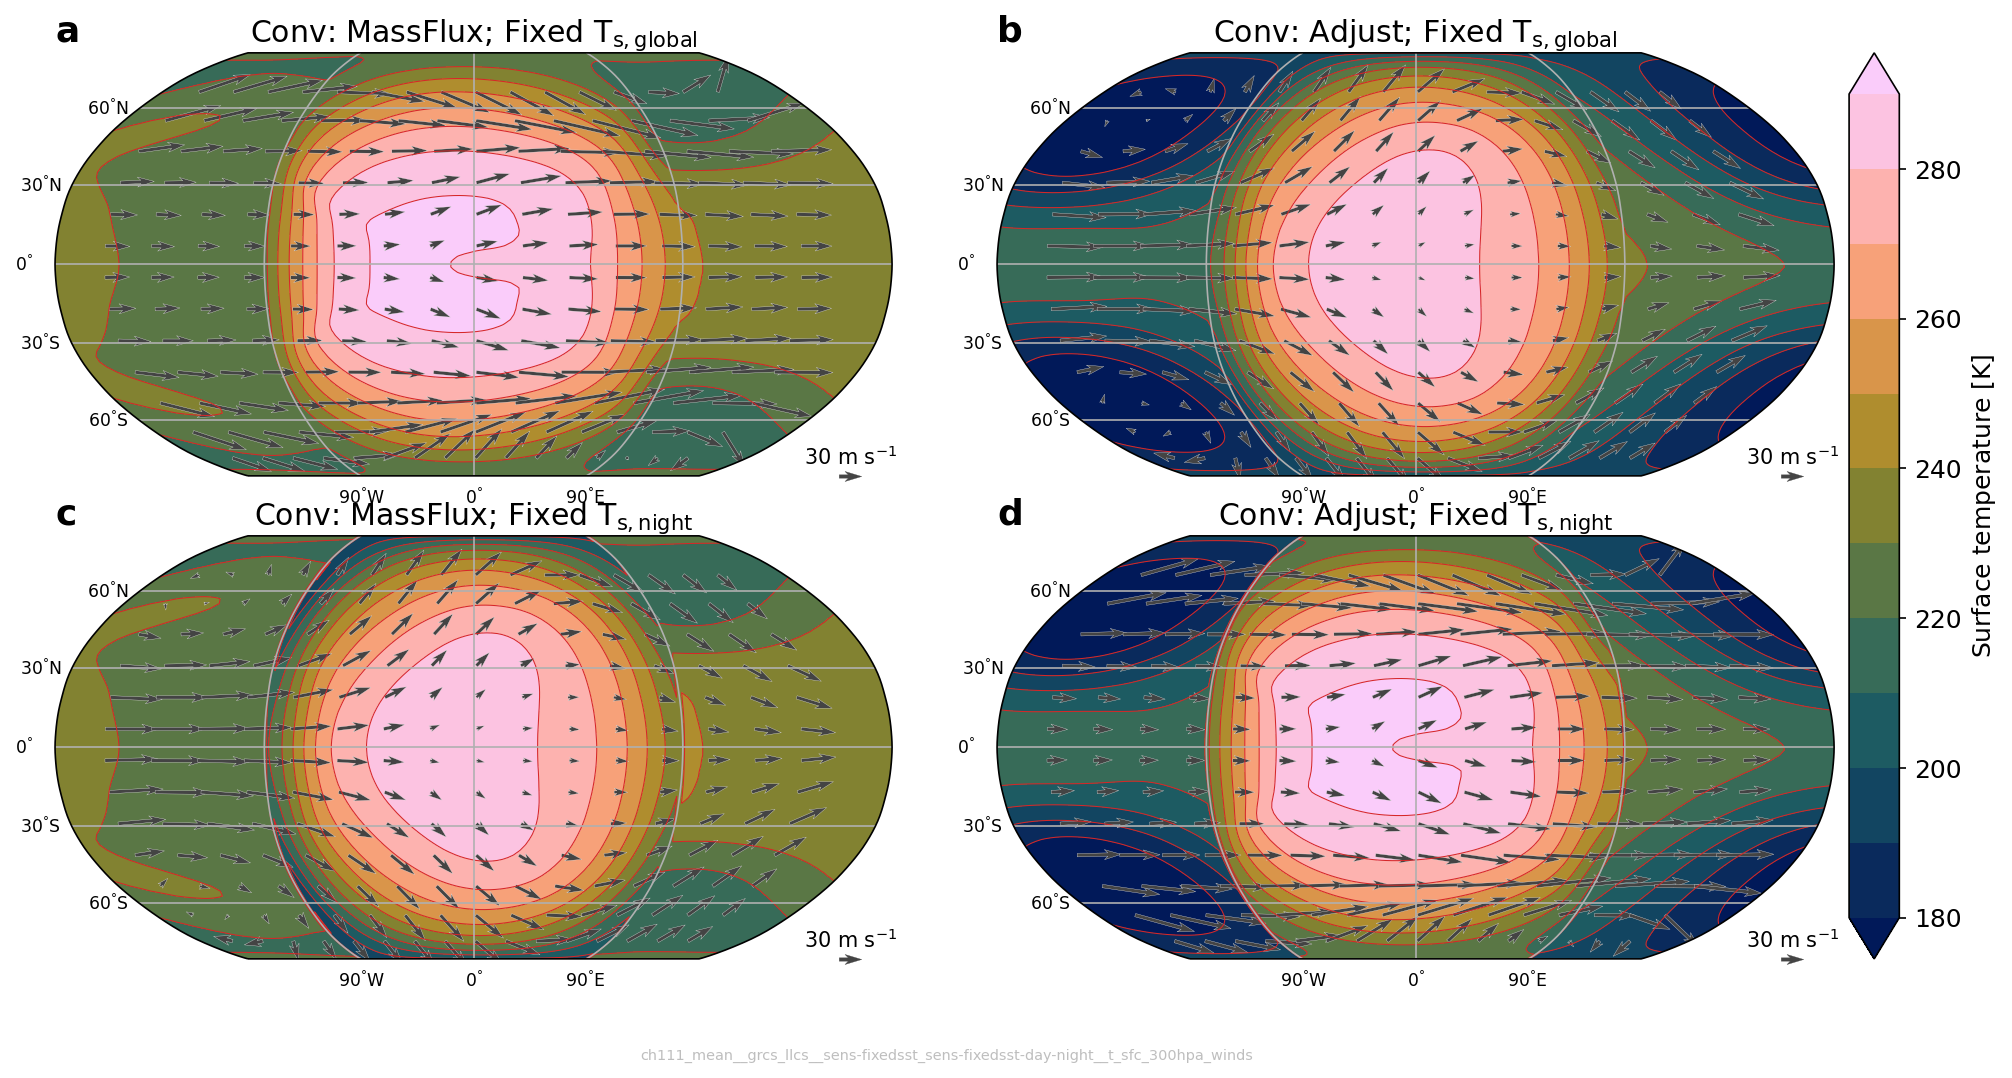

In [62]:
imgname = f"{img_prefix}__{'_'.join(chosen_opt_labels)}__t_sfc_{P_LEV1}hpa_winds"

fig, axgr = make_map_figure(2, 2, **KW_AXGR)
cax = axgr.cbar_axes[0]
axs = np.array(axgr.axes_column)

iletters = subplot_label_generator()
for ax in axs.T.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)

for (suite_label, suite_prop), axcol in zip(SUITE_LABELS.items(), axs):
    for opt_label, ax in zip(chosen_opt_labels, axcol):
        ax.set_title(
            f'{suite_prop["title"]}; {OPT_LABELS[opt_label]["title"]}', **KW_MAIN_TTL
        )
        sim_label = f"{suite_label}_{opt_label}"
        the_run = runs[sim_label]
        the_run_p = runs_p[sim_label]

        t_sfc_map = time_mean(the_run.t_sfc)
        print(t_sfc_map.data.min(), t_sfc_map.data.max())
        u_map = time_mean(the_run_p.u.extract(p_lev_constr1))
        v_map = time_mean(the_run_p.v.extract(p_lev_constr1))

        p0 = draw_scalar_cube(
            t_sfc_map,
            ax,
            method="contourf",
            cmap=cm.batlow,
            cax=cax,
            levels=np.arange(180, 291, 10),
            extend="both",
        )
        draw_scalar_cube(
            t_sfc_map,
            ax,
            method="contour",
            colors="tab:red",
            levels=np.arange(180, 291, 10),
            linewidths=0.5,
        )
        draw_vector_cubes(
            u_map,
            v_map,
            ax,
            xstride=8,
            ystride=6,
            qk_ref_wspd=30,
            kw_quiver={**KW_QUIVER, **KW_CART},
            kw_quiverkey=KW_QUIVERKEY,
            quiverkey_xy=(0.95, 0.00),
        )


cax.set_ylabel("Surface temperature [$K$]", **KW_CBAR_TTL)
# figsave(fig, plotdir / imgname)